# YOLO

> Python module for detecting objects via YOLO

In [ ]:
#| default_exp vision.yolo

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
from typing import Optional
from ultralytics import YOLO
import json
import os

## Detecting objects with YOLO

Apart from processing images with GPT vision model, we can also use a YOLO model to detect objects in images. This section demonstrate this process, starting with a captured image of Santa Claus Village:

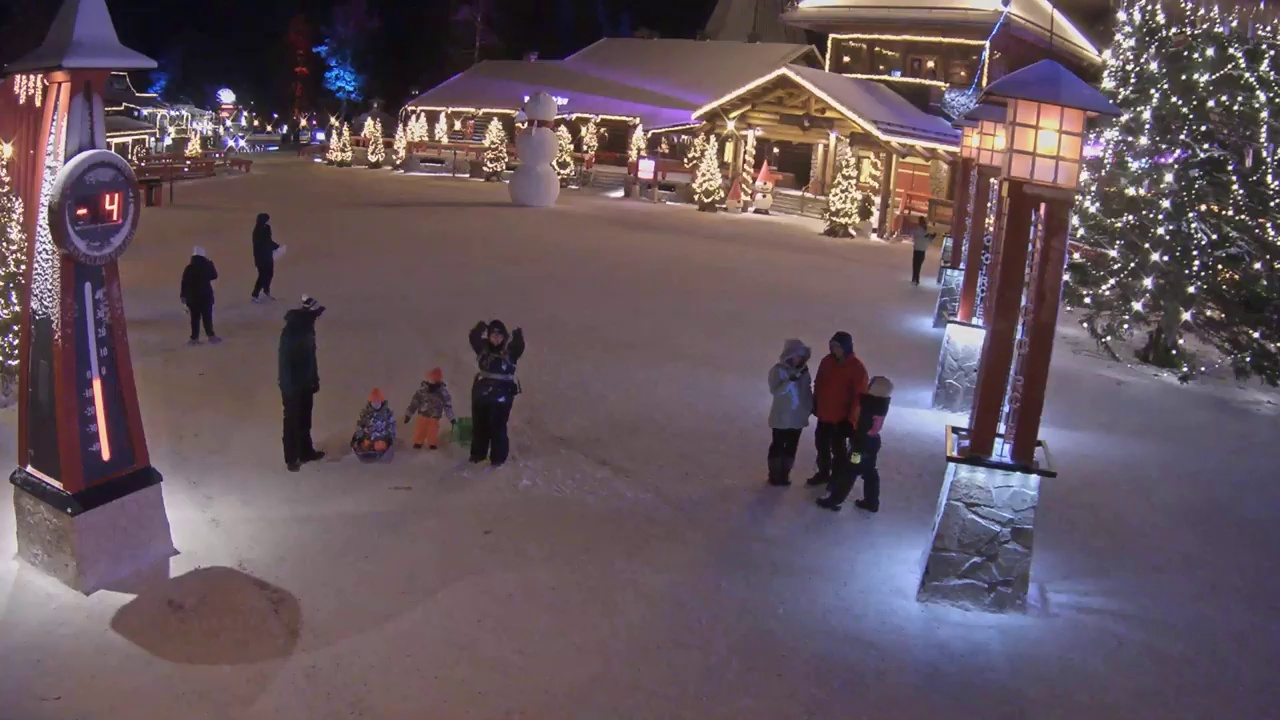

In [ ]:
#| eval: false
import os
from IPython.display import Image

data_path = os.getenv("LLMCAM_DATA", "../data")
file = f"{data_path}/cap_2024.12.09_20:33:06_santaclausvillege.jpg"
Image(file)

Detect objects as bounding boxes with a YOLO model:


image 1/1 /home/nghivo/tinyMLaaS/llmcam/data/cap_2024.12.09_20:33:06_santaclausvillege.jpg: 384x640 12 persons, 13.4ms
Speed: 1.3ms preprocess, 13.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


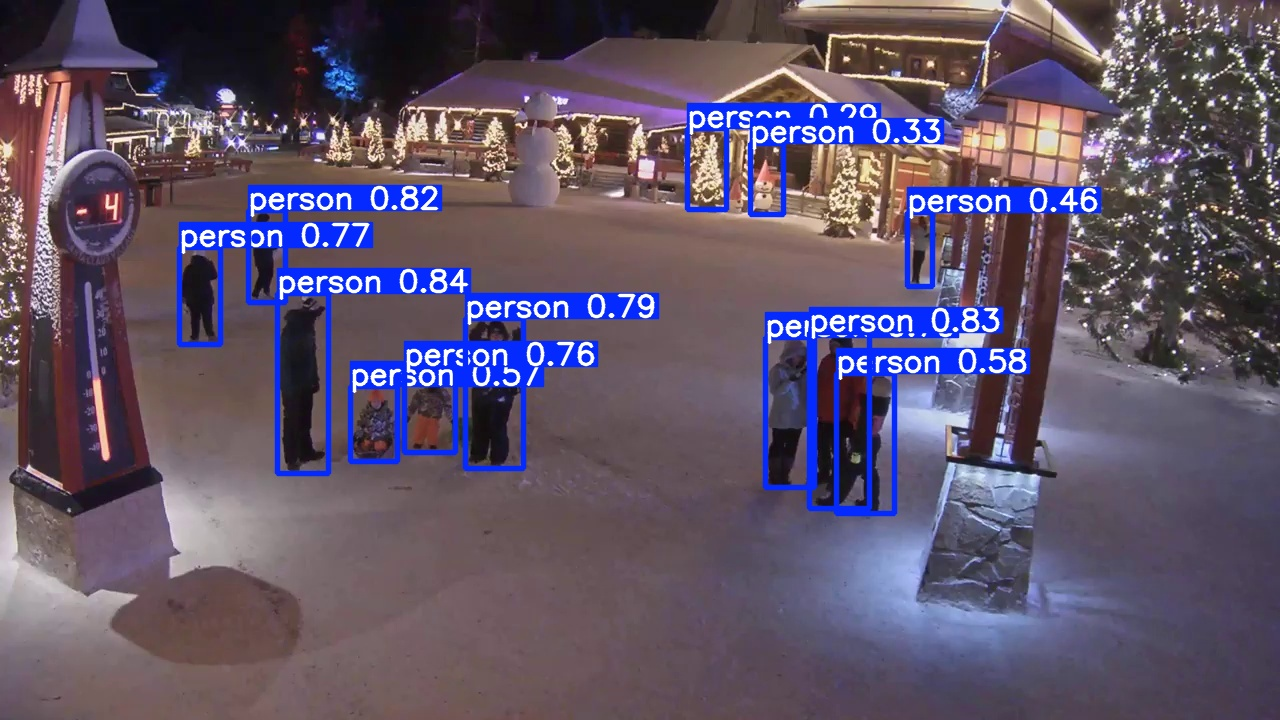

In [ ]:
#| eval: false
# Load pretrained YOLO model
model = YOLO('yolov8s.pt')

# Get detections
result = model(file, conf=0.25, exist_ok=True)[0]

# Save results as image
save_dir = os.getenv("LLMCAM_DATA", "../data")
output_path = file.split("/")[-1]
result.save(filename=f"{save_dir}/detection_{output_path}")

# Display results
Image(f"{save_dir}/detection_{output_path}")

Detected objects can be summarized with counts of objects per class. This summarized information is useful as tool results for our GPT Function calling framework.

In [ ]:
#| eval: false
# Count objects per class
dict = {}
for c in result.boxes.cls:
    dict[model.names[int(c)]] = dict.get(model.names[int(c)], 0) + 1
json.dumps(dict)

'{"person": 12}'

Modularized operations:

In [ ]:
#| export
def detect_objects(
    image_path: str, # Path/URL of image
    conf: Optional[float] = 0.25 # Confidence threshold
) -> str: # JSON format of detection results
    """Detect object in the input image using YOLO model."""
    # Load pretrained YOLO model
    model = YOLO('yolov8s.pt')
    
    # Get detections
    result = model(image_path, conf=conf, exist_ok=True)[0]

    # Save results as image
    save_dir = os.getenv("LLMCAM_DATA", "../data")
    output_path = image_path.split("/")[-1]
    result.save(filename=f"{save_dir}/detection_{output_path}")

    # Return summary of detection results as counts per class
    dict = {}
    for c in result.boxes.cls:
        dict[model.names[int(c)]] = dict.get(model.names[int(c)], 0) + 1
    
    # Return results as JSON-formatted string
    return json.dumps(dict)

In [ ]:
show_doc(detect_objects)

---

[source](https://github.com/ninjalabo/llmcam/blob/main/llmcam/vision/yolo.py#L14){target="_blank" style="float:right; font-size:smaller"}

### detect_objects

>      detect_objects (image_path:str, conf:Optional[float]=0.25)

*Detect object in the input image using YOLO model.*

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| image_path | str |  | Path/URL of image |
| conf | Optional | 0.25 | Confidence threshold |
| **Returns** | **str** |  | **JSON format of detection results** |

Test usage:

In [ ]:
#| eval: false
detect_objects(file, 0.25)


image 1/1 /home/nghivo/tinyMLaaS/llmcam/data/cap_2024.12.09_20:33:06_santaclausvillege.jpg: 384x640 12 persons, 12.4ms
Speed: 1.7ms preprocess, 12.4ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)


'{"person": 12}'

## Simulated GPT workflow

This section tests integrating with our current GPT framework. This function can be used in combination with previous functions in the `vision` module:

In [ ]:
#| eval: false
from llmcam.core.fc import *
from llmcam.core.fn_to_schema import function_schema
from llmcam.vision.ytlive import capture_youtube_live_frame
from llmcam.vision.gpt4v import ask_gpt4v_about_image_file

tools = [
    function_schema(capture_youtube_live_frame, "Youtube Live Capture"),
    function_schema(ask_gpt4v_about_image_file, "GPT4 Vision"),
    function_schema(detect_objects, "YOLO Object Detection")
]
messages = form_msgs([
    ("system", "You are a helpful system administrator. Use the supplied tools to assist the user."),
    ("user", "Capture an image from this Youtube Live at Santa Claus Village: https://www.youtube.com/watch?v=Cp4RRAEgpeU")
])
complete(messages, tools=tools)
print_msgs(messages)

[youtube] Extracting URL: https://www.youtube.com/watch?v=Cp4RRAEgpeU
[youtube] Cp4RRAEgpeU: Downloading webpage
[youtube] Cp4RRAEgpeU: Downloading ios player API JSON
[youtube] Cp4RRAEgpeU: Downloading mweb player API JSON
[youtube] Cp4RRAEgpeU: Downloading m3u8 information
[youtube] Cp4RRAEgpeU: Downloading m3u8 information
>> System:
You are a helpful system administrator. Use the supplied tools to assist the user.
>> User:
Capture an image from this Youtube Live at Santa Claus Village:
https://www.youtube.com/watch?v=Cp4RRAEgpeU
>> Assistant:
I have captured an image from the YouTube Live stream at Santa Claus Village. If you need further
analysis or have any questions about this image, feel free to ask!


In [ ]:
#| eval: false
# Continue the conversation and detect the number of people in the image
messages.append(form_msg("user", "Can you find out how many people there are in this image?"))
complete(messages, tools=tools)
print_msgs(messages)


image 1/1 /home/nghivo/tinyMLaaS/llmcam/data/cap_2024.12.12_09:37:48_None.jpg: 384x640 19 persons, 2 backpacks, 48.7ms
Speed: 5.4ms preprocess, 48.7ms inference, 189.9ms postprocess per image at shape (1, 3, 384, 640)
>> System:
You are a helpful system administrator. Use the supplied tools to assist the user.
>> User:
Capture an image from this Youtube Live at Santa Claus Village:
https://www.youtube.com/watch?v=Cp4RRAEgpeU
>> Assistant:
I have captured an image from the YouTube Live stream at Santa Claus Village. If you need further
analysis or have any questions about this image, feel free to ask!
>> User:
Can you find out how many people there are in this image?
>> Assistant:
There are 19 people detected in the captured image from the YouTube Live stream at Santa Claus
Village. If you have any more questions or need further assistance, feel free to ask!


In [ ]:
#|hide
import nbdev; nbdev.nbdev_export()